# Poisson Process Fun Time

In [115]:
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

In [154]:
def h(p):
    return p

def method_1(lam, n_sims, t, seed):
    key = jax.random.PRNGKey(seed)

    Ns = jax.random.poisson(key=key, lam=lam, shape=(n_sims,))
    max_Ns = jnp.max(Ns)
    order = jnp.arange(0, max_Ns)
 
    def stat(N, key): 
        p = jax.random.uniform(key=key, shape=(max_Ns,))
        p_sub = jnp.where(order < N, p, jnp.nan)
        return jnp.sum(h(p_sub) * (p_sub < t))
    
    keys = jax.random.split(key, num=n_sims)
        
    stat_vmapped = jax.vmap(stat, in_axes=(0,0))
    stat_vmapped_jit = jax.jit(stat_vmapped)
    out = stat_vmapped_jit(Ns, keys)
    return out

def method_2(lam, n_sims, t, seed, n_begin=10):
    key = jax.random.PRNGKey(seed)

    # sample Exp(lam) until the running sum is >= 1, then take everything before that point.
    # If X_1,..., X_n ~ Exp(lam) and T_i = sum_{j=1}^i X_j,
    # then (T_1,..., T_{n-1}) | T_n = t ~ (U_{(1)}, ..., U_{(n-1)}) where each U_i ~ Unif(0, t)
    # 
    # Sampling procedure:
    # - Increase n until T_n >= 1
    # - Sample (T_1,..., T_{n-1}) | T_n via formula above.
    # - Sum over h(T_i) 1{T_i < t}

    def find_n_T_n(n_begin, key):
        n = n_begin
        T = 0
        def body_fun(tup, key):
            n, _ = tup
            n = n + n_begin
            _, key = jax.random.split(key)
            return (n, jax.random.gamma(key=key, a=n) / lam)
        out = jax.lax.while_loop(
            lambda tup: tup[1] < 1, 
            lambda tup: body_fun(tup, key), 
            (n, T))
        return jnp.array(out)

    keys = jax.random.split(key, num=n_sims)
    NT = jax.jit(jax.vmap(find_n_T_n, in_axes=(None, 0)))(n_begin, keys)
    
    N_max = int(jnp.max(NT[:,0]))
    order = jnp.arange(0, N_max)
    def stat(nt, key):
        n, t_n = nt
        unifs = jax.random.uniform(key=key, shape=(N_max,))
        unifs = jnp.where(order < (n-1), unifs, jnp.inf)
        unifs_sorted = jnp.sort(unifs)
        Ts = t_n * unifs_sorted
        return jnp.sum(h(Ts) * (Ts < t))

    stat_vmapped = jax.vmap(stat, in_axes=(0,0))
    stat_vmapped_jit = jax.jit(stat_vmapped)

    keys = jax.random.split(keys[-1], num=n_sims)
    return stat_vmapped_jit(NT, keys)


In [158]:
lam = 100
n_sims = 100000
t = 0.2
seed = 69

In [159]:
out_1 = method_1(lam=lam, n_sims=n_sims, t=t, seed=seed)
out_2 = method_2(lam=lam, n_sims=n_sims, t=t, seed=seed)

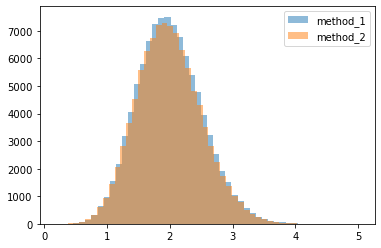

In [160]:
plt.hist(out_1, bins=50, alpha=0.5, label='method_1')
plt.hist(out_2, bins=50, alpha=0.5, label='method_2')
plt.legend()
plt.show()